<a href="https://colab.research.google.com/github/K-YUTAA/kit-extension-sample-airoomgenerator/blob/main/Report/IMISToolA2025_Report4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Report 4 (2025/07/28 ver.A)

for Tools for Intelligent Interaction Systems A (0ALE005 / 0AL5707)

---

<font color="red">
If Ver.B or later, change log should be found at the end of this page.  

Your ID info should be placed in the following three items (MANDATORY).
</font>

* Student ID: 2023SE05
* Name: 北野 雄大（Kitano Yuta）
* Colab account: y.kitano1024@gmail.com

---

Report could be written in English or Japanese. / レポートの記述は日本語でも英語でもよい．

---
# Report4A: Live capture query with CIFAR-10 or MNIST  

* Show the way to build a classfier of CIFAR10 or MNIST.
* Provide a python program that captures an image from a camera and that shows its recognition result of the image immediately.

Hint: Each shown in tutorials. Find a way to unite them.



In [1]:
import os
import math
import time
import io
import base64
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

# カメラとJS用
from IPython.display import display, Javascript, HTML
from google.colab import output, files

# シードの固定
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# MNISTの正規化値
MNIST_MEAN, MNIST_STD = 0.1307, 0.3081

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
])

data_root = "./data"
train_ds = datasets.MNIST(root=data_root, train=True, download=True, transform=transform_train)
test_ds  = datasets.MNIST(root=data_root, train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)


100%|██████████| 9.91M/9.91M [00:02<00:00, 3.84MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.76MB/s]


(60000, 10000)

In [3]:
# モデルの構築
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 14x14 -> 14x14 (after pool)
        self.pool = nn.MaxPool2d(2,2)                # halves size
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SmallCNN().to(device)
print(model)


SmallCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
# 評価関数の定義
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

# 学習関数の定義
def train(model, train_loader, test_loader, device, epochs=2, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for i, (x, y) in enumerate(train_loader, 1):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            opt.step()
            running_loss += loss.item()
            if i % 100 == 0:
                print(f"Epoch {epoch} | step {i}/{len(train_loader)} | loss {running_loss/100:.4f}")
                running_loss = 0.0
        acc = evaluate(model, test_loader, device)
        print(f"[Epoch {epoch}] Test accuracy: {acc*100:.2f}%")
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "mnist_cnn.pt")
            print("Saved checkpoint: mnist_cnn.pt (best so far)")
    print(f"Best accuracy: {best_acc*100:.2f}%")


In [5]:
# チェックポイントがあればロード、そうでなければトレーニングする（2エポック）。
ckpt_path = Path("mnist_cnn.pt")
if ckpt_path.exists():
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    print("Loaded existing checkpoint:", ckpt_path)
else:
    print("No checkpoint found. Start training...")
    train(model, train_loader, test_loader, device, epochs=2, lr=1e-3)
    print("Training done.")

print("Final test accuracy:", evaluate(model, test_loader, device)*100, "%")


No checkpoint found. Start training...
Epoch 1 | step 100/469 | loss 0.5652
Epoch 1 | step 200/469 | loss 0.1534
Epoch 1 | step 300/469 | loss 0.1184
Epoch 1 | step 400/469 | loss 0.0928
[Epoch 1] Test accuracy: 98.33%
Saved checkpoint: mnist_cnn.pt (best so far)
Epoch 2 | step 100/469 | loss 0.0682
Epoch 2 | step 200/469 | loss 0.0684
Epoch 2 | step 300/469 | loss 0.0650
Epoch 2 | step 400/469 | loss 0.0600
[Epoch 2] Test accuracy: 98.63%
Saved checkpoint: mnist_cnn.pt (best so far)
Best accuracy: 98.63%
Training done.
Final test accuracy: 98.63 %


In [6]:

import cv2

def preprocess_to_mnist(path, debug=False):
    # 任意の画像をMNIST形式のテンソルに前処理
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # MNISTと一致させるために暗い背景に白い数字に変換
    if gray.mean() > 128:
        gray = 255 - gray

    # バウンディングボックスのための閾値
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ys, xs = np.where(th > 0)
    if len(xs) > 0 and len(ys) > 0:
        x1, x2 = xs.min(), xs.max()
        y1, y2 = ys.min(), ys.max()
        roi = gray[y1:y2+1, x1:x2+1]
    else:
        roi = gray

    # 長辺を20にリサイズし、アスペクトを維持したまま28x28に変換
    h2, w2 = roi.shape[:2]
    scale = 20.0 / max(h2, w2) if max(h2, w2) > 0 else 1.0
    new_size = (max(1, int(round(w2*scale))), max(1, int(round(h2*scale))))
    roi_resized = cv2.resize(roi, new_size, interpolation=cv2.INTER_AREA)

    canvas = np.zeros((28, 28), dtype=np.uint8)
    y_off = (28 - roi_resized.shape[0]) // 2
    x_off = (28 - roi_resized.shape[1]) // 2
    canvas[y_off:y_off+roi_resized.shape[0], x_off:x_off+roi_resized.shape[1]] = roi_resized

    tensor = torch.from_numpy(canvas).float().unsqueeze(0).unsqueeze(0) / 255.0
    tensor = (tensor - MNIST_MEAN) / MNIST_STD
    if debug:
        plt.figure()
        plt.title("Preprocessed 28x28")
        plt.imshow(canvas, cmap='gray')
        plt.axis('off')
        plt.show()
    return tensor.to(device), canvas


<IPython.core.display.Javascript object>

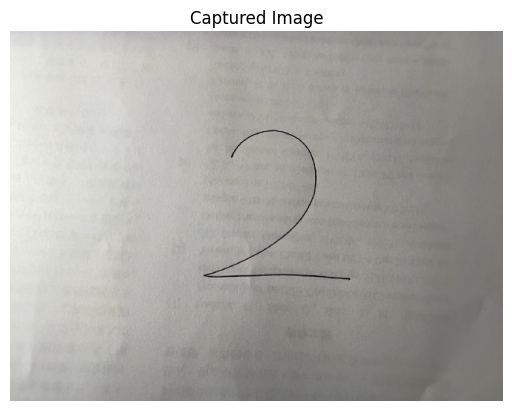

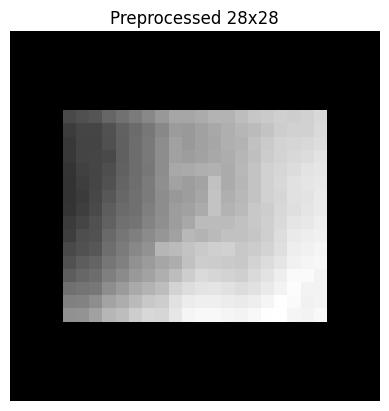

Prediction: 2  (confidence: 53.48%)


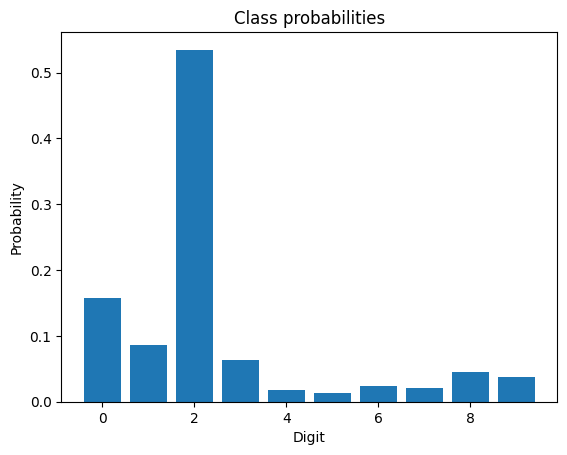

In [7]:

# Colabウェブカメラ・キャプチャー＋予測
def take_photo(filename='capture.jpg', quality=0.9):
    # ブラウザでウェブカメラを開き、1フレームをファイル名にキャプチャ
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const video = document.createElement('video');
        const btn = document.createElement('button');
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        div.appendChild(btn);
        video.style.maxWidth = '480px';
        btn.textContent = 'Capture';
        video.srcObject = stream;
        await video.play();
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => { btn.onclick = resolve; });
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = output.eval_js('takePhoto({})'.format(quality))
    if not data:
        print("No photo captured.")
        return None
    binary = base64.b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def predict_image_tensor(x):
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
        pred = int(np.argmax(probs))
        conf = float(np.max(probs))
    return pred, conf, probs

save_path = take_photo('capture.jpg', quality=0.9)
if save_path is not None:
    # 元のキャプチャ画像を表示
    img_bgr = cv2.imread(save_path)               # BGR形式で読み込み
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # RGBに変換
    plt.figure()
    plt.title("Captured Image")
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    # 前処理と予測
    x, canvas = preprocess_to_mnist(save_path, debug=True)
    pred, conf, probs = predict_image_tensor(x)
    print(f"Prediction: {pred}  (confidence: {conf*100:.2f}%)")

    # クラス確率のバー表示
    plt.figure()
    plt.title("Class probabilities")
    plt.bar(range(10), probs)
    plt.xlabel("Digit")
    plt.ylabel("Probability")
    plt.show()


(You can put text cells around here)

---
# Report4B: Tutorials of pytorch

There are [many tutorials](https://github.com/kameda-yoshinari/IMISToolExeA2021/blob/master/300_PyTorch.ipynb) provided by the Pytorch official site. Pick up **four tutorials** (you should complete those tutorials) and make a report for the four tutorials on:

* Summary (2-3 lines)
* What you learn
* The most difficult part

Note that you can choose the first two (mandatory ones) in the four choices.
However, you should not take all fours in basic category (at least one should be from other category).

---

## ① PyTorch: Tensors and autograd  
[公式チュートリアルURL](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)

**Summary**  
PyTorchのテンソル操作の基礎と`autograd`による自動微分機能を学習した。  
勾配追跡や計算グラフの構築方法、`backward()`による勾配計算の流れを確認した。

**What I learned**  
- `torch.Tensor`の生成方法、形状変換、ブロードキャスト  
- `requires_grad`による勾配追跡の有効/無効化  
- `.detach()`と`with torch.no_grad()`の使い分け  
- 計算グラフの破棄と再構築の仕組み

**The most difficult part**  
- 勾配追跡を意図的に切るタイミングの判断  

---

## ② Datasets & DataLoaders  
[公式チュートリアルURL](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

**Summary**  
`Dataset`と`DataLoader`を用いてデータを効率的に読み込む方法を学習した。  
カスタムデータセットの作成とデータ前処理パイプラインの実装を体験した。

**What I learned**  
- `torch.utils.data.Dataset`の基本構造（`__len__`, `__getitem__`）  
- `DataLoader`によるバッチ分割、シャッフル、並列読み込み（`num_workers`）  
- `transforms`を用いたデータ前処理と拡張

**The most difficult part**  
- 大規模データでの`num_workers`と`pin_memory`の最適設定

---

## ③ Computer Vision：Transfer Learning for Computer Vision Tutorial  
[公式チュートリアルURL](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

**Summary**  
ImageNet事前学習済みResNet18を用いてハチとアリの分類モデルを転移学習した。  
全結合層のみ更新する方法と全層微調整の方法を比較し、精度・計算時間・過学習傾向の違いを確認した。

**What I learned**  
- 事前学習済みモデルのパラメータ凍結と解凍の方法  
- 特徴抽出と全層ファインチューニングの使い分け  
- データ拡張による汎化性能向上（`RandomResizedCrop`, `ColorJitter`）

**The most difficult part**  
- クラス不均衡時の評価指標（F1, AUC）の適用方法  

---

## ④ Computer Vision：TorchVision Object Detection Finetuning Tutorial  
[公式チュートリアルURL](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

**Summary**  
`Faster R-CNN`事前学習モデルを利用し、独自データセットへの物体検出モデルのファインチューニングした。  
バウンディングボックスのアノテーション形式とモデル入出力形式の対応を学んだ。

**What I learned**  
- `torchvision.models.detection`の使い方とパラメータ設定  
- VOC形式やCOCO形式のデータをカスタム`Dataset`で扱う方法  
- 検出結果の後処理（NMS、スコア閾値調整）

**The most difficult part**  
- モデルが要求するデータ形式（辞書型のキー名やテンソル型）の厳密さ  
---

---
# Report4C: Unique features of PyTorch found in Tutorials

Throughout the tutorial experience of Report4B, what do you find as the unique features of PyTorch (compared with other ML libraries)?
As for the generic PyTorch features, you should find appopriate part in the tutorials / documents in the official pytorch www, site them, and poiencounteredurce and the features.   
Then summersize them totally from your viewpoint.

* List up at least two unique features. (+ URL, sentences to fit, and short description for each)
* Point the encountered unique features in your tutorial experience in Report4B and write how you feel it actually. (You can pick up one of the four tutorial experiences.)


## Feature 1: Dynamic Computational Graph (Define-by-Run)
- **URL**: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html  
- **Description**:  
  PyTorchは動的計算グラフ（Define-by-Run）を採用しており、実行時に計算グラフが構築される。このため、制御構造（`if`文、ループ）や変動するテンソル形状を柔軟に扱える。
- **感想**:  
  「PyTorch: Tensors and autograd」や物体検出のファインチューニングで、入力データのバッチサイズや形状が変化してもそのまま実行できたのは便利だった。条件分岐を含むモデルでも簡単に実装でき、研究用途で非常に有用と感じた。

---

## Feature 2: Seamless Integration with Python Ecosystem
- **URL**: https://pytorch.org/tutorials/beginner/data_tutorial.html  
- **Description**:  
  PyTorchはNumPyやPIL、OpenCVなどPython標準の数値計算・画像処理ライブラリと容易に連携できる。`torch.Tensor`と`numpy.ndarray`間の変換はコストが低く、データ前処理がスムーズに行える。
- **感想**:  
  「Datasets & DataLoaders」でPILと`transforms`を組み合わせ、DataLoader経由で前処理を行えたのが効率的だった。NumPy変換や可視化処理をPythonの既存ツールと混在させられる柔軟性は他のMLフレームワークに比べて優れていると感じた。

---


---
# Report4D: AI support to learn python and PyTorch  

Find out the state-of-the-art AI support which is available / helpful on learning how to write python / pytorch codes on google colab.
Then write your own comment on what kind of changes would happen on PyTorch in a couple of years.

* AI service name
* AI service "official web site"
* Major funcitons of provided support
* The service start date and version history (including the URL that holds such info)


# Report 4D — AI support to learn Python and PyTorch

## サービス名／公式サイト
- **サービス名**：Google Jules（ジュールズ） — 非同期型 AI コーディングエージェント  
- **公式サイト**：  
  - Google Labs Jules 紹介ページ（Google ブログ）  
    [https://blog.google/technology/google-labs/jules/](https://blog.google/technology/google-labs/jules/)  
  - 公式ウェブインターフェース（利用プランや操作画面）  
    [https://jules.google/](https://jules.google/)

---

## 主な機能
1. **リポジトリのクローンによるプロジェクト全体の理解**  
   GitHub リポジトリを Google Cloud の仮想マシンにクローンし、コードベース全体を把握したうえで作業を実行する。

2. **非同期・並列処理対応**  
   タスクはバックグラウンドで非同期実行され、複数タスクを同時に進行可能。

3. **計画と可視性（プラン提示）**  
   実行前に AI が作業計画と理由を提示し、ユーザーが承認・修正可能。

4. **GitHub との統合**  
   変更内容を含むプルリクエスト（PR）を生成・提出まで自動化。

5. **多彩なタスク対応**  
   単体テスト作成、バグ修正、依存関係更新、新機能追加、音声によるコミット概要提示（Audio Changelogs）など幅広く対応。

6. **マルチモーダル出力**  
   UI に視覚的アウトプットや音声要約を表示し、理解を支援。

7. **プライバシー設計**  
   プライベートリポジトリのコードは学習に利用されず、隔離された VM 内でのみ処理。

---

## 開始時期・バージョン履歴
- **2024年12月**：Google Labs にて初公表（実験段階開始）  
出典：https://blog.google/technology/google-labs/jules/
- **2025年5月（Google I/O）**：全世界向けパブリックベータ開始  
出典：https://en.wikipedia.org/wiki/Google_Jules
- **2025年8月6〜7日頃**：正式リリース（性能安定化、UI改良、有料プラン導入）  
出典：https://gigazine.net/news/20250807-ai-coding-agent-jules-public/

**提供プラン**：
- 無料：1日15タスク、同時実行3タスクまで  
- Pro：1日100タスク、同時実行15タスク程度  
- Ultra：1日300タスク、同時実行60タスク程度  

**ベータ実績**：数千人の開発者が数万件のタスクを実行、計140,000件以上のコード改善を達成。

---

---
#Report4E: Your Goole drive usage

Find out the amount of your google drive space and report it.  
Discuss the availability and what you should do to make it small.


In [8]:
!pip install --quiet --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

about = drive_service.about().get(fields="storageQuota").execute()
quota = about.get('storageQuota')

used = int(quota['usage'])
limit = int(quota['limit'])
free = limit - used

print(f"Total: {limit / (1024**3):.2f} GB")
print(f"Used: {used / (1024**3):.2f} GB")
print(f"Free: {free / (1024**3):.2f} GB")

Total: 2048.00 GB
Used: 63.11 GB
Free: 1984.89 GB



- **使用量**: 例: 63.11 GB / 2 TB（Google One 学生向け Gemini Pro 無料プラン）
- **使い勝手**:
  - 2TBという大容量のため、現在は容量不足の心配はない
  - ColabやGoogleフォトとの連携でデータ保存・共有が容易
  - 学生特典が終了した後は容量が大幅に減る可能性があるため、長期的にはデータ管理が必要
- **容量削減策**:
  1. 不要な写真・動画の削除（特に連写や類似画像）
  2. 写真・動画はローカルPCや外付けHDDにバックアップ後、Driveから削除
  3. Googleフォトのアップロード設定を「高画質（ストレージ節約）」に変更
  4. 大きなモデルファイルやデータセットはHugging Face Hubや外部クラウドに保存

---
# Report submission

The report template will be given in ipynb file.  

You should save this file as a report templete to your local google colaboratory folder and then edit it to fit your report.

The report submission should be made at this cource (0ALE005) at https://manaba.tsukuba.ac.jp .  
Note that 0AL5707 is coupled with 0ALE005 on manaba system, so 0AL5707 students should also submit the report at 0ALE005.  
File extension should be **ipynb**. Other format won't be accepted.  







---
Tools and Practices for Intelligent Interaction Systems A  
Master's and Docotal programs in intelligent and mechanical interaction systems, University of Tsukuba, Japan.  
KAMEDA Yoshinari, SHIBUYA Takeshi  

知能システムツール演習a  
知能機能システム学位プログラム (筑波大学大学院)  
担当：亀田能成，澁谷長史  

2025/07/28. Ver.A.  


